In [19]:
# 1. Import necessary libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
plt.rcParams['figure.figsize'] = [20, 8]

In [20]:
#Load dataset
df = pd.read_csv('../../Dataset/Gold.csv')
df = df.reset_index()['Close']
df

0       1313.075
1       1316.500
2       1318.875
3       1327.875
4       1319.590
          ...   
2339    2361.310
2340    2339.110
2341    2343.380
2342    2327.820
2343    2327.820
Name: Close, Length: 2344, dtype: float64

In [21]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df).reshape(-1, 1))

In [22]:
# 4. Split train and test data
train_size = int(0.6 * len(df1))
test_size = len(df1) - train_size
train_data = df1[:train_size]
test_data = df1[train_size:]

In [23]:
# 5. Function to create dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [24]:
# 6. Create train and test datasets
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [25]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [26]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(time_step, 1)))
model.add(GRU(32))
model.add(Dense(1))

In [27]:
#Use Adam optimizer with learning rate = 0.001
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='mean_squared_error')

In [28]:
#9. Fit model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1, callbacks=[early_stop])

Epoch 1/100
21/21 [==============================] - 10s 219ms/step - loss: 0.0401 - val_loss: 0.0173
Epoch 2/100
21/21 [==============================] - 3s 146ms/step - loss: 0.0046 - val_loss: 6.4983e-04
Epoch 3/100
21/21 [==============================] - 3s 152ms/step - loss: 5.8099e-04 - val_loss: 7.9772e-04
Epoch 4/100
21/21 [==============================] - 3s 143ms/step - loss: 3.2572e-04 - val_loss: 3.6535e-04
Epoch 5/100
21/21 [==============================] - 3s 144ms/step - loss: 2.7870e-04 - val_loss: 3.7690e-04
Epoch 6/100
21/21 [==============================] - 3s 151ms/step - loss: 2.7358e-04 - val_loss: 3.3814e-04
Epoch 7/100
21/21 [==============================] - 3s 153ms/step - loss: 2.6832e-04 - val_loss: 3.2844e-04
Epoch 8/100
21/21 [==============================] - 5s 229ms/step - loss: 2.6694e-04 - val_loss: 3.5123e-04
Epoch 9/100
21/21 [==============================] - 3s 160ms/step - loss: 2.5346e-04 - val_loss: 3.1035e-04
Epoch 10/100
21/21 [==========

In [29]:
# 10. Predict test data
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

27/27 [==============================] - 2s 31ms/step


In [30]:
# 11. Inverse transform test data
train_data1 = df[:train_size]
test_data1 = df[train_size:]
x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

In [31]:
# 12. Evaluate model accuracy
test_mse = mean_squared_error(y_test1[time_step + 1:], y_pred)
print('Testing MSE:', test_mse)

test_rmse = math.sqrt(test_mse)
print('Testing RMSE:', test_rmse)

test_mape = mean_absolute_percentage_error(y_test1[time_step + 1:], y_pred)
print('Testing MAPE:', test_mape)

Testing MSE: 454.10365210208494
Testing RMSE: 21.309707930942764
Testing MAPE: 0.008031047301572038


In [32]:
# 13. Define prediction function
def predict(n_steps, temp_input_1, x_input_1, model, day_predict):
    lst_output = []
    temp_input = temp_input_1.copy()
    x_input = x_input_1.copy()
    i = 0
    
    while(i < day_predict):
        if(len(temp_input) > n_steps):
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

In [33]:
# Predict next 30, 60, 90 days
n_steps = 100
x_input = test_data[len(test_data) - n_steps:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_30 = predict(n_steps, temp_input, x_input, model, 30)
lst_output_60 = predict(n_steps, temp_input, x_input, model, 60)
lst_output_90 = predict(n_steps, temp_input, x_input, model, 90)

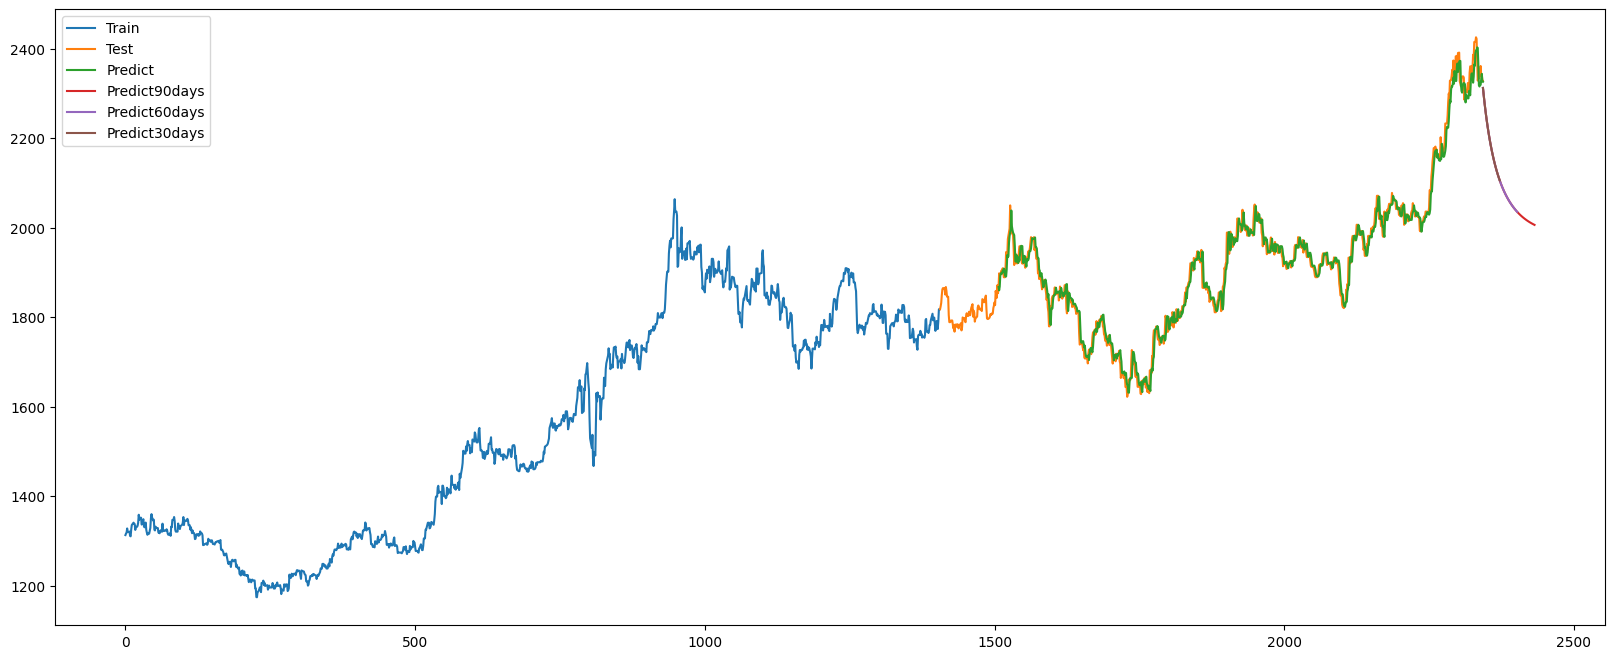

<Figure size 1600x900 with 0 Axes>

In [34]:
#Plot results
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_90))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_60))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_30))

plt.legend(['Train','Test','Predict','Predict90days','Predict60days','Predict30days'])
plt.figure(figsize=(16,9))
plt.show()